In [1]:
#read the data
import pandas as pd
df = pd.read_csv('abstract_narrations.csv')

In [2]:
#import libraries
import numpy as np
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
#transform to lower, remove the new line and the punctuation
df['narration'] = df['narration'].str.lower()
df['narration'] = df['narration'].str.replace('&lt;br/&gt;', '')
punctuations = '@#!?+&*[]-%.:/();,$=><|{}^' + "'`" + '_'
for punctuation in punctuations:
    df['narration'] = df['narration'].str.replace(punctuation, '')
    
#tokenize and lemmatize
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]
df['narration'] = df['narration'].apply(lemmatize_text)

#remove stop words
all_stopwords = stopwords.words('english')
df['narration'] = df['narration'].apply(lambda x: [word for word in x if not word in all_stopwords])
df['narration'] = [' '.join(map(str, word)) for word in df['narration']]

/tmp/ipykernel_33923/2347415378.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['narration'] = df['narration'].str.replace(punctuation, '')


In [4]:
df.head()

,title,narration
0,Adaptive dynamic coordination of damping contr...,last decade global environmental pollution con...
1,RAPID: On-mask Chemical Modulation of Respirat...,nontechnical abstract spread infectious respir...
2,Collaborative Research: Biomass burning smoke ...,microbe found environment play essential role ...
3,SBIR Phase I: AK-423: A broad-spectrum antivi...,broader impact commercial potential small busi...
4,The Nature of Coupled Heat and Mass Transport ...,goal project understand coupled heat masstrans...


In [5]:
#vectorizer the data to a matrix
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df['narration'])

In [6]:
# find the clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

/home/cristine.scheibler/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [7]:
#the shape is (13157, 76449) therefor 13157 vectors with 76449 dimensions each
#beeing impossible to visualize the data 
X.shape

(13157, 18400)

In [8]:
#use the PCA to reduces the dimensionality and visualize using 2 Principal Component
pca = PCA(n_components=2)
pca_vecs = pca.fit_transform(X.toarray())
pc1 = pca_vecs[:, 0]
pc2 = pca_vecs[:, 1]

In [9]:
#create a new DataFrame to keep the data 
dfc = pd.DataFrame()
dfc['cluster'] = kmeans.labels_
dfc['pc1'] = pc1
dfc['pc2'] = pc2

In [10]:
dfc.head()

,cluster,pc1,pc2
0,1,-0.069223,0.060949
1,2,-0.063931,-0.000121
2,0,-0.056368,-0.162543
3,2,-0.073267,0.035834
4,3,-0.124712,-0.006641


In [11]:
#find the keyword from every cluster, to create a labeling for each cluster  
keywords = {}
dft = pd.DataFrame(X.todense()).groupby(kmeans.labels_).mean()
terms = vectorizer.get_feature_names_out()
for i,r in dft.iterrows():
    #get the 5 most commun words in the terms
    keywords[i] = ','.join([terms[t] for t in np.argsort(r)[-5:]])

In [12]:
#remap the cluster to change the ID of the cluster to the keywords
dfc['cluster'] = dfc['cluster'].map(keywords)

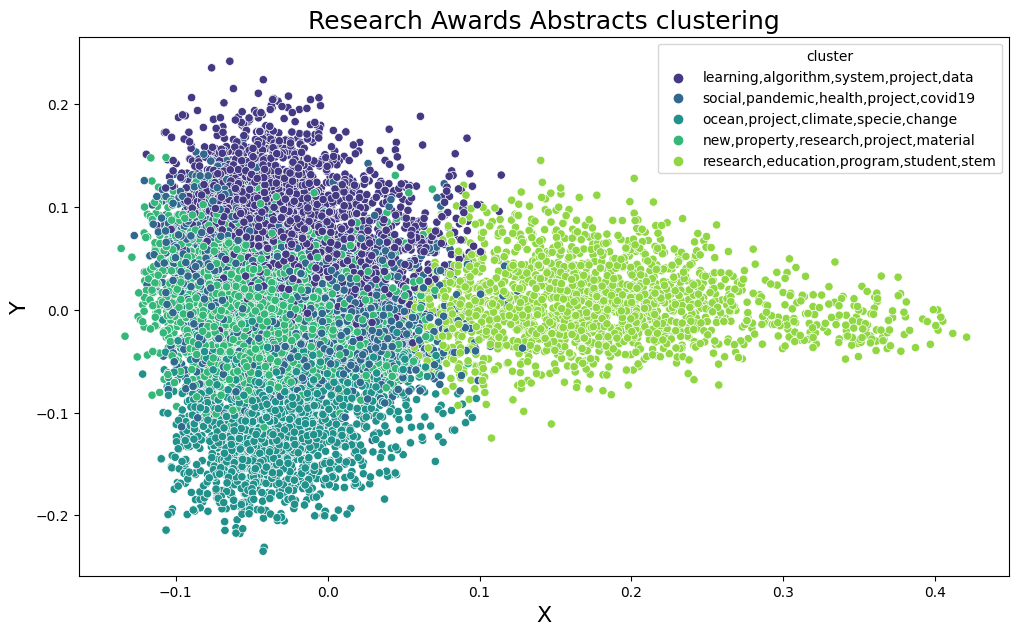

In [13]:
#plot the results 
plt.figure(figsize=(12, 7))
plt.title("Research Awards Abstracts clustering", fontdict={"fontsize": 18})
plt.xlabel("X", fontdict={"fontsize": 16})
plt.ylabel("Y", fontdict={"fontsize": 16})
sns.scatterplot(data=dfc, x='pc1', y='pc2', hue='cluster', palette="viridis")
plt.show()